# Neural ODE for Warm Rain

**Goal:** Train a Neural ODE to learn the time derivatives of bulk moments:
- Input: Current state (qc, nc, qr, nr) + environmental parameters (q_w0, r_0, ν)
- Output: Time derivatives (dqc/dt, dnc/dt, dqr/dt, dnr/dt)
- Use ODE solver for multi-step predictions

Using `torchode` for ODE integration.

In [2]:
!pip install torchode

import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import torchode as to

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

  Using cached torchode-1.0.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached torchtyping-0.1.5-py3-none-any.whl.metadata (9.5 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
Using cached torchode-1.0.0-py3-none-any.whl (30 kB)
Using cached torchtyping-0.1.5-py3-none-any.whl (17 kB)
Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torchode]
Using device: cpu


Feature names: ['qc', 'nc', 'qr', 'nr', 'q_w0', 'r_0', 'nu']

Derivative names: ['dqc/dt', 'dnc/dt', 'dqr/dt', 'dnr/dt']

Time step (dt): 20.0 seconds


In [3]:
# Load preprocessed data
data_dir = Path('./data')
data = np.load(data_dir / 'node_preprocessed.npz')

# Load normalized data
X_train = torch.FloatTensor(data['X_train_norm']).to(device)
Y_train = torch.FloatTensor(data['Y_train_norm']).to(device)
X_test = torch.FloatTensor(data['X_test_norm']).to(device)
Y_test = torch.FloatTensor(data['Y_test_norm']).to(device)

# Load scalers and metadata
with open(data_dir / 'scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    scaler_X = scalers['scaler_X']
    scaler_Y = scalers['scaler_Y']

**Create DataLoaders**

In [4]:
# Create datasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Create dataloaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 512
Training batches: 77
Test batches: 20


## Neural ODE Model

The ODE function learns: $\frac{d\mathbf{M}}{dt} = f_{\theta}(\mathbf{M}, \mathbf{p})$

where:
- $\mathbf{M}$ = bulk moments [qc, nc, qr, nr]
- $\mathbf{p}$ = environmental parameters [q_w0, r_0, ν] (constant)
- $f_{\theta}$ = neural network

In [5]:
class ODEFunc(nn.Module):
    """Neural network that defines the ODE system.
    
    Takes as input:
    - t: time (not used, autonomous system)
    - y: current state [batch, 4] - the bulk moments
    - args: environmental parameters [batch, 3] - constant during integration
    
    Returns:
    - dydt: time derivatives [batch, 4]
    """
    
    def __init__(self, hidden_dim=128, n_layers=4):
        super(ODEFunc, self).__init__()
        
        # Input: 4 (bulk moments) + 3 (env params) = 7
        # Output: 4 (derivatives)
        input_dim = 7
        output_dim = 4
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, t, y, args):
        """
        t: time (scalar or [batch])
        y: state [batch, 4] - bulk moments
        args: dict with 'env_params' [batch, 3] - environmental parameters
        """
        env_params = args['env_params']
        
        # Concatenate state and environmental parameters
        inputs = torch.cat([y, env_params], dim=-1)  # [batch, 7]
        
        # Compute derivatives
        dydt = self.net(inputs)  # [batch, 4]
        
        return dydt


class NeuralODE(nn.Module):
    """Neural ODE wrapper for training and prediction."""
    
    def __init__(self, ode_func, solver='dopri5', atol=1e-6, rtol=1e-6):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func
        self.solver = solver
        self.atol = atol
        self.rtol = rtol
        
        # Create torchode term and solver
        self.term = to.ODETerm(ode_func)
        self.step_method = getattr(to, solver.capitalize())(term=self.term)
        self.step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=self.term)
        self.adjoint = to.AutoDiffAdjoint(self.step_method, self.step_size_controller)
    
    def forward(self, y0, t_span, env_params):
        """
        Integrate ODE from t0 to t1.
        
        y0: initial state [batch, 4]
        t_span: time span [t0, t1] - tensor of shape [2]
        env_params: environmental parameters [batch, 3]
        
        Returns:
        - solution at t1 [batch, 4]
        """
        args = {'env_params': env_params}
        
        # Solve ODE
        problem = to.InitialValueProblem(y0=y0, t_eval=t_span)
        solution = self.adjoint.solve(problem, args=args)
        
        # Return final state (at t1)
        return solution.ys[-1]
    
    def predict_derivative(self, X):
        """
        Direct prediction of derivatives (for training).
        
        X: input features [batch, 7] = [moments (4) + env_params (3)]
        
        Returns:
        - derivatives [batch, 4]
        """
        y = X[:, :4]  # bulk moments
        env_params = X[:, 4:]  # environmental parameters
        
        # Evaluate ODE function at current state
        args = {'env_params': env_params}
        dydt = self.ode_func(None, y, args)
        
        return dydt


# Create model
ode_func = ODEFunc(hidden_dim=128, n_layers=4).to(device)
model = NeuralODE(ode_func, solver='dopri5', atol=1e-6, rtol=1e-6).to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel created with {n_params:,} trainable parameters")
print(model.ode_func)


Model created with 51,076 trainable parameters
ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=4, bias=True)
  )
)


### Training Setup

In [6]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # Optimizer: Adam with weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
) # Scheduler: ReduceLROnPlateau

# Training configuration
n_epochs = 100
print_every = 5

# History tracking
history = {
    'train_loss': [],
    'test_loss': [],
    'epoch': []
}

print("Training configuration:")
print(f"  Epochs: {n_epochs}")
print(f"  Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  Batch size: {batch_size}")

Training configuration:
  Epochs: 100
  Learning rate: 0.001
  Batch size: 512


/srv/conda/envs/notebook/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training Loop

In [7]:
def train_epoch(model, loader, criterion, optimizer):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    
    for X_batch, Y_batch in loader:
        optimizer.zero_grad()
        
        # Predict derivatives directly (no ODE integration for training)
        Y_pred = model.predict_derivative(X_batch)
        
        # Compute loss
        loss = criterion(Y_pred, Y_batch)
        
        # Backpropagation
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
    
    return total_loss / len(loader.dataset)


def evaluate(model, loader, criterion):
    """Evaluate on test set."""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            Y_pred = model.predict_derivative(X_batch)
            loss = criterion(Y_pred, Y_batch)
            total_loss += loss.item() * X_batch.size(0)
    
    return total_loss / len(loader.dataset)


# Training loop
print("Starting training...\n")
best_test_loss = float('inf')

for epoch in range(1, n_epochs + 1):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    
    # Evaluate
    test_loss = evaluate(model, test_loader, criterion)
    
    # Update scheduler
    scheduler.step(test_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['epoch'].append(epoch)
    
    # Save best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
        }, data_dir / 'best_node_model.pt')
    
    # Print progress
    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch [{epoch:3d}/{n_epochs}] | "
              f"Train Loss: {train_loss:.6f} | "
              f"Test Loss: {test_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

print(f"Best test loss: {best_test_loss:.6f}")

Starting training...

Epoch [  1/100] | Train Loss: 0.614568 | Test Loss: 0.342786 | LR: 1.00e-03
Epoch [  5/100] | Train Loss: 0.070872 | Test Loss: 0.079698 | LR: 1.00e-03
Epoch [ 10/100] | Train Loss: 0.030932 | Test Loss: 0.033273 | LR: 1.00e-03
Epoch [ 15/100] | Train Loss: 0.016044 | Test Loss: 0.018612 | LR: 1.00e-03
Epoch [ 20/100] | Train Loss: 0.009537 | Test Loss: 0.012600 | LR: 1.00e-03
Epoch [ 25/100] | Train Loss: 0.006842 | Test Loss: 0.007840 | LR: 1.00e-03
Epoch [ 30/100] | Train Loss: 0.006255 | Test Loss: 0.005576 | LR: 1.00e-03
Epoch [ 35/100] | Train Loss: 0.004390 | Test Loss: 0.009334 | LR: 1.00e-03
Epoch [ 40/100] | Train Loss: 0.003452 | Test Loss: 0.003004 | LR: 1.00e-03
Epoch [ 45/100] | Train Loss: 0.005788 | Test Loss: 0.003901 | LR: 1.00e-03
Epoch [ 50/100] | Train Loss: 0.002016 | Test Loss: 0.002622 | LR: 1.00e-03
Epoch [ 55/100] | Train Loss: 0.002062 | Test Loss: 0.003252 | LR: 1.00e-03
Epoch [ 60/100] | Train Loss: 0.002027 | Test Loss: 0.003745 | LR:

### Plot Training History

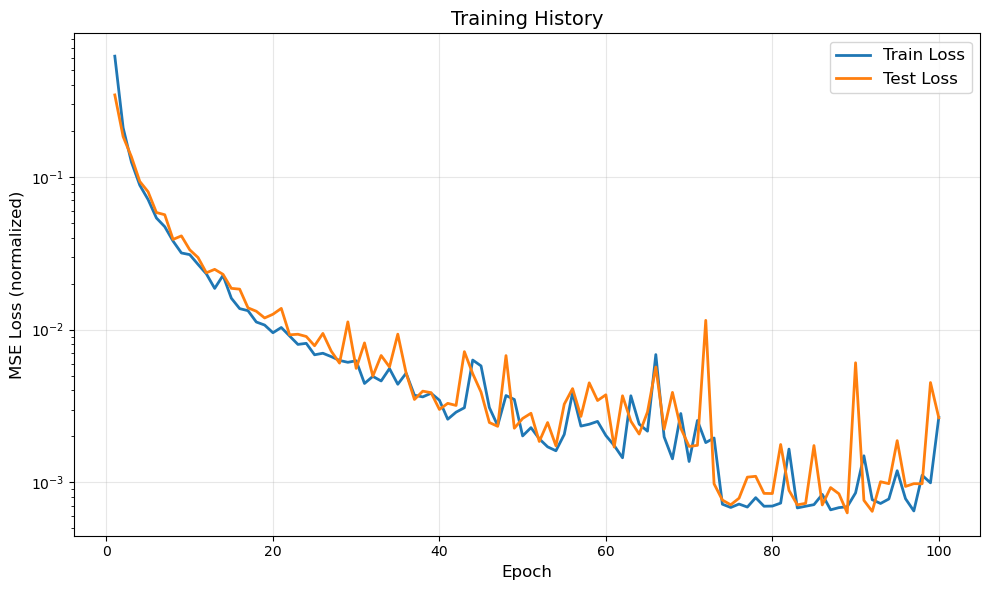

Saved: training_history.png


In [8]:
# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(history['epoch'], history['train_loss'], label='Train Loss', linewidth=2)
ax.plot(history['epoch'], history['test_loss'], label='Test Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss (normalized)', fontsize=12)
ax.set_title('Training History', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: training_history.png")

Save best model and will evaluate predictions on test set.

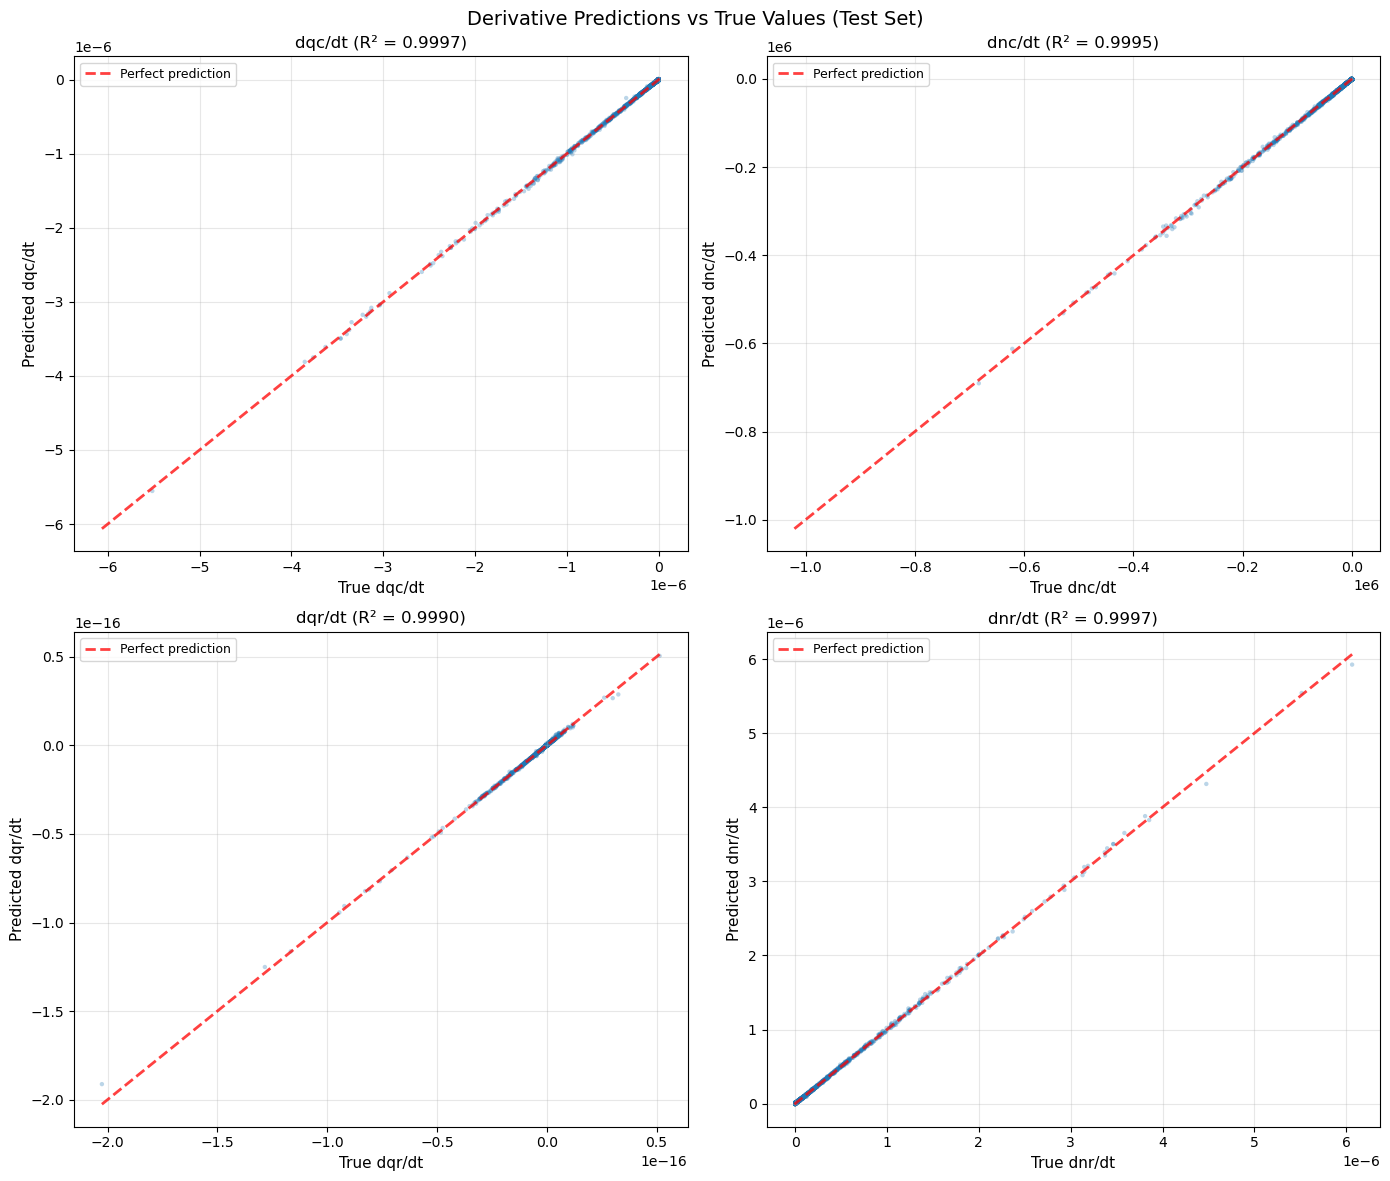

Saved: derivative_predictions.png


In [12]:
# Scatter plots of predictions vs true values
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
deriv_names = ['dqc/dt', 'dnc/dt', 'dqr/dt', 'dnr/dt']

for i, (ax, name) in enumerate(zip(axes.flat, deriv_names)):
    # Subsample for plotting (if too many points)
    n_plot = min(5000, len(Y_true_orig))
    indices = np.random.choice(len(Y_true_orig), n_plot, replace=False)
    
    ax.scatter(Y_true_orig[indices, i], Y_pred_orig[indices, i], 
               alpha=0.3, s=10, edgecolors='none')
    
    # Add diagonal line
    lims = [min(Y_true_orig[:, i].min(), Y_pred_orig[:, i].min()),
            max(Y_true_orig[:, i].max(), Y_pred_orig[:, i].max())]
    ax.plot(lims, lims, 'r--', alpha=0.75, linewidth=2, label='Perfect prediction')
    
    # Compute R²
    r2 = r2_score(Y_true_orig[:, i], Y_pred_orig[:, i])
    
    ax.set_xlabel(f'True {name}', fontsize=11)
    ax.set_ylabel(f'Predicted {name}', fontsize=11)
    ax.set_title(f'{name} (R² = {r2:.4f})', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Derivative Predictions vs True Values (Test Set)', fontsize=14)
plt.tight_layout()
plt.savefig('derivative_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: derivative_predictions.png")

## Multi-Step Trajectory Prediction

Use the ODE solver to integrate forward in time and compare with true trajectories.